In [1]:

from google.colab import userdata

TOKEN = userdata.get('GITHUB_PAT')

REPO_NAME = "Grecotel-Project"
USERNAME = "VassilisK2001"

In [2]:
!git clone https://{TOKEN}@github.com/{USERNAME}/{REPO_NAME}.git

Cloning into 'Grecotel-Project'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 98 (delta 40), reused 69 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (98/98), 28.42 MiB | 8.14 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Updating files: 100% (33/33), done.


In [3]:
%cd Grecotel-Project/

/content/Grecotel-Project


In [4]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 27.1 MB/s eta 0:00:00


In [14]:
import os
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from transformers import Trainer
from transformers import DistilBertTokenizer
from transformers import TrainingArguments, DistilBertForSequenceClassification
from datasets import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
import optuna

nltk.download('vader_lexicon')
nltk.download('punkt_tab')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:

filename = 'cleaned_dataset_tripadvisor-reviews_2025-11-01_14-21-09-431.json'
json_path = os.path.join('data', 'cleaned', filename)

df = pd.read_json(json_path, orient='records')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19493 entries, 0 to 19492
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             19493 non-null  int64 
 1   lang           19493 non-null  object
 2   rating         19493 non-null  int64 
 3   travelDate     19466 non-null  object
 4   publishedDate  19493 non-null  object
 5   tripType       17379 non-null  object
 6   userLocation   11260 non-null  object
 7   review_text    19493 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.2+ MB


,id,lang,rating,travelDate,publishedDate,tripType,userLocation,review_text
0,1016346537,el,1,2025-07-01,2025-07-03,BUSINESS,None,Απαράδεκτο grecotel.. Απαράδεκτο! Έφτασα μετά ...
1,1015574543,en,5,2025-06-01,2025-06-28,FAMILY,None,Family vacation. I was afraid of what the acco...
2,987362026,el,3,2024-12-01,2025-01-02,COUPLES,None,Αδιαφορο. Το ξενοδοχείο χρήζει ανακαίνισης. Τα...
3,979445372,tr,1,2024-11-01,2024-11-10,FAMILY,None,Kahvaltı kuyruğu ve personelin kabalığı. Çocuk...
4,960799391,en,5,2023-08-01,2024-07-23,COUPLES,None,Place to stay in Alexandropoli. Wonderful stay...


In [7]:
# Convert data types
df['travelDate'] = pd.to_datetime(df['travelDate'], errors='coerce')
df['publishedDate'] = pd.to_datetime(df['publishedDate'], errors='coerce')

In [8]:
# Keep only relevant data
df_filtered = df[df['travelDate'] >= '2023-06-01'].copy()

# Keep only english reviews for now
df_filtered = df_filtered[df_filtered['lang'] == 'en']

# Keep only relevant columns
df_filtered = df_filtered[['id', 'review_text']]
df_filtered.head()

,id,review_text
1,1015574543,Family vacation. I was afraid of what the acco...
4,960799391,Place to stay in Alexandropoli. Wonderful stay...
5,960211568,The worst room i’ve ever stayed in Greece.. Th...
6,952565999,"Large, modern hotel on the coast, with reasona..."
8,917123208,Excellent located. Nice beach and excellent lo...


In [9]:
# Define Aspect Keywords
ASPECT_KEYWORDS = {
    "ROOM": ["room", "suite", "ac", "air conditioning", "balcony", "bed", "pillow",  "mattress", "shower",
             "kitchen", "bathroom", "toilet"],
    "FOOD": ["food", "restaurant", "breakfast", "buffet", "dinner", "bar", "ice cream", "drink", "choice",
             "meal", "menu"],
    "SERVICE": [ "service", "room service", "customer service", "amenities", "staff", "reception", "waiter",
                "waitress","host", "hostess", "housekeeping", "concierge", "manager", "friendly", "helpful", "rude",
                 "warm", "welcoming","transfer"],
    "FACILITIES": ["pool", "water park", "sunbed", "sun bed", "jacuzzi", "gym", "spa", "sauna", "steam room",
                   "activities", "fitness", "sports","wifi"],
    "LOCATION": ["location", "close", "view", "sea view", "port", "city", "beach", "airport", "town", "centre"],
    "VALUE_FOR_MONEY": ["price", "pay", "expensive", "worth", "cheap", "luxury", "cost", "money", "value",
                        "reasonable", "pricey", "overpriced"],
    "CLEANLINESS": ["clean", "cleaner", "dirty", "tidy", "maintained"],
    "COMFORT": ["rest", "comfortable", "comfort", "sleep", "quiet", "relax", "privacy", "noise"]
}

In [15]:
vader = SentimentIntensityAnalyzer()

def get_vader_sentiment(sentence):
    """
    Returns 'positive', 'negative', or 'neutral'
    based on the VADER compound score.
    """
    compound_score = vader.polarity_scores(sentence)['compound']
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Main Labeling Function
def create_absa_dataset(df: pd.DataFrame, aspect_map: dict):
    """
    Iterates through reviews and sentences to build
    a programmatically labeled ABSA dataset.
    """
    labeled_data = []

    for index, row in df.iterrows():
        review_id = row['id']
        full_review_text = row['review_text']

        # Skip null reviews
        if pd.isna(full_review_text):
            continue

        # Split the review into individual sentences
        sentences = sent_tokenize(full_review_text)

        for sentence in sentences:
            sentence_lower = sentence.lower()
            found_aspects = set()

            # Check this sentence for each of our aspect keywords
            for aspect, keywords in aspect_map.items():
                for keyword in keywords:
                    # re.escape() handles keywords with spaces like "air conditioning"
                    if re.search(r'\b' + re.escape(keyword) + r'\b', sentence_lower):
                        found_aspects.add(aspect)
                        # We can 'break' here since we found this aspect
                        # No need to check other keywords for the *same* aspect
                        break

            if found_aspects:
                # Get the sentiment of the sentence
                sentiment = get_vader_sentiment(sentence)

                # Add a new row for each aspect found
                for aspect in found_aspects:
                    labeled_data.append({
                        'review_id': review_id,
                        'aspect': aspect,
                        'sentence': sentence,
                        'sentiment': sentiment
                    })

    # Convert the final list into a new DataFrame
    absa_df = pd.DataFrame(labeled_data)

    # Remove duplicates
    absa_df = absa_df.drop_duplicates().reset_index(drop=True)

    return absa_df

In [16]:
df_absa = create_absa_dataset(df_filtered, ASPECT_KEYWORDS)
df_absa.info()
df_absa.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45764 entries, 0 to 45763
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  45764 non-null  int64 
 1   aspect     45764 non-null  object
 2   sentence   45764 non-null  object
 3   sentiment  45764 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


,review_id,aspect,sentence,sentiment
0,1015574543,LOCATION,I was afraid of what the accomodation would be...,positive
1,1015574543,FOOD,I was afraid of what the accomodation would be...,positive
2,1015574543,FACILITIES,I was afraid of what the accomodation would be...,positive
3,1015574543,ROOM,I was afraid of what the accomodation would be...,positive
4,960799391,CLEANLINESS,Rooms are clean and comfortable.,positive


In [17]:
# Excluding neutral sentiment
df_absa = df_absa[df_absa['sentiment'] != 'neutral']
df_absa.shape

(38331, 4)

In [18]:
df_absa.groupby('aspect')['sentiment'].value_counts(normalize=True).unstack(fill_value=0) * 100

sentiment,negative,positive
aspect,,
CLEANLINESS,9.526262,90.473738
COMFORT,9.961686,90.038314
FACILITIES,18.108365,81.891635
FOOD,12.865563,87.134437
LOCATION,10.780287,89.219713
ROOM,24.002883,75.997117
SERVICE,9.068752,90.931248
VALUE_FOR_MONEY,22.156045,77.843955


/tmp/ipython-input-3930964485.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


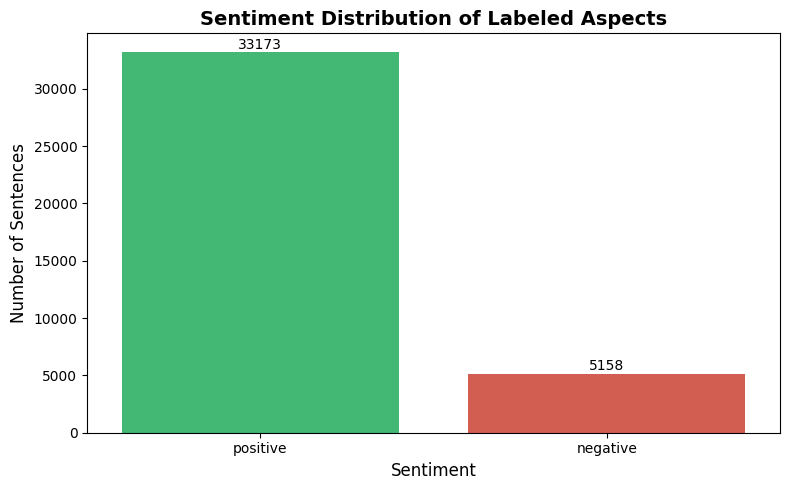

In [19]:
plt.figure(figsize=(8, 5))
sentiment_counts = df_absa['sentiment'].value_counts()

ax = sns.barplot(
    x=sentiment_counts.index,
    y=sentiment_counts.values,
    palette=['#2ecc71', '#e74c3c'],
    order=['positive', 'negative']
)

plt.title('Sentiment Distribution of Labeled Aspects', fontsize=14, weight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)

# Add count labels on top of bars
for i, count in enumerate(sentiment_counts.reindex(['positive', 'negative']).fillna(0)):
    ax.text(i, count + 50, f'{count:.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

/tmp/ipython-input-520158464.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


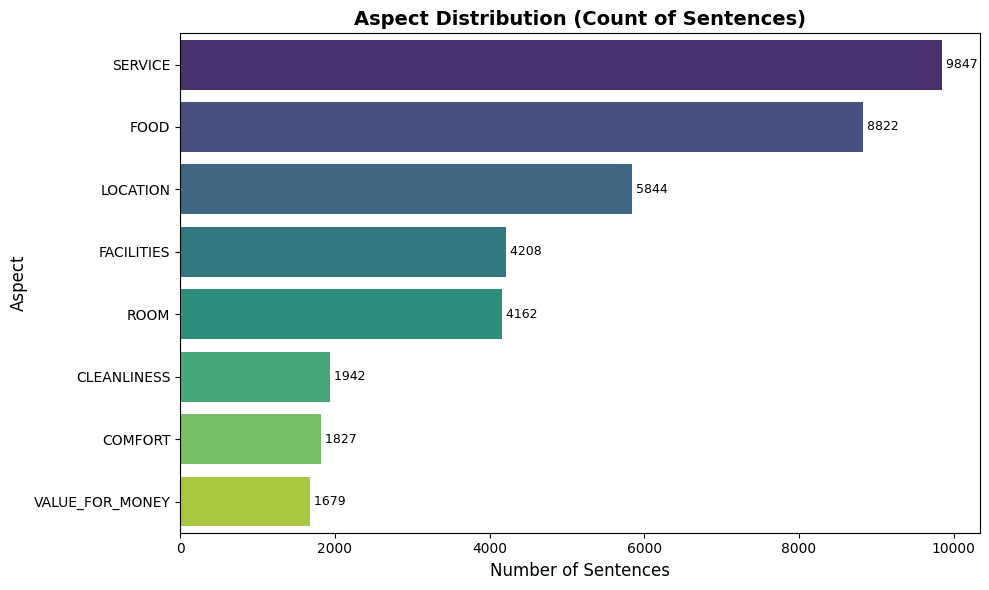

In [20]:
plt.figure(figsize=(10, 6))
aspect_counts = df_absa['aspect'].value_counts()

# Use a horizontal bar plot for easier reading
ax = sns.barplot(
    x=aspect_counts.values,
    y=aspect_counts.index,
    orient='h',
    palette='viridis'
)

plt.title('Aspect Distribution (Count of Sentences)', fontsize=14, weight='bold')
plt.xlabel('Number of Sentences', fontsize=12)
plt.ylabel('Aspect', fontsize=12)

# Add count labels to the bars
for i, count in enumerate(aspect_counts):
    ax.text(count, i, f' {count}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [21]:
# Calculate Sentiment Weights ---
sentiment_classes = np.unique(df_absa['sentiment'])
sentiment_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=sentiment_classes,
    y=df_absa['sentiment']
)
sentiment_weight_map = dict(zip(sentiment_classes, sentiment_weights_values))

# Calculate Aspect Weights ---
aspect_classes = np.unique(df_absa['aspect'])
aspect_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=aspect_classes,
    y=df_absa['aspect']
)
aspect_weight_map = dict(zip(aspect_classes, aspect_weights_values))

# Map weights back to the DataFrame
df_absa['sentiment_weight'] = df_absa['sentiment'].map(sentiment_weight_map)
df_absa['aspect_weight'] = df_absa['aspect'].map(aspect_weight_map)

# Calculate the Final 'sample_weight'
df_absa['sample_weight'] = df_absa['sentiment_weight'] * df_absa['aspect_weight']

# Prepare data for Hugging Face
df_absa['label'] = df_absa['sentiment'].map({'positive': 1, 'negative': 0})


In [22]:
class WeightedTrainer(Trainer):
    """
    A custom trainer that applies sample weights to the loss calculation.
    """
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):

        weights = inputs.pop("sample_weight")

        outputs = model(**inputs)
        logits = outputs.get("logits")

        labels = inputs.get("labels")

        loss_fct = nn.CrossEntropyLoss(reduction="none")
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        # Multiply the per-sample loss by its weight
        weighted_loss = loss * weights

        # Average the weighted loss
        final_loss = weighted_loss.mean()

        return (final_loss, outputs) if return_outputs else final_loss

In [23]:
# Load Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create the Dataset object from pandas DataFrame
hf_dataset = Dataset.from_pandas(df_absa[['sentence', 'aspect', 'label', 'sample_weight']])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [24]:
# Tokenize the data
def tokenize_function(examples):
    # create the "[CLS] sentence [SEP] aspect [SEP]" format
    tokenized = tokenizer(
        examples["sentence"],
        examples["aspect"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    tokenized["label"] = examples["label"]
    tokenized["sample_weight"] = examples["sample_weight"]
    return tokenized

In [25]:
tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)

columns_to_keep = ['input_ids', 'attention_mask', 'label', 'sample_weight']

columns_to_remove = [col for col in tokenized_dataset.column_names if col not in columns_to_keep]
tokenized_dataset = tokenized_dataset.remove_columns(columns_to_remove)

# This splits 80% for (Train+Val) and 20% for the final "holdout" Test set.
train_val_split = tokenized_dataset.train_test_split(
    test_size=0.2,
    seed=42
)
# This is your new "final exam" test set (20% of total)
test_dataset = train_val_split['test']

# This is your 80% chunk that you will use for training
train_val_dataset = train_val_split['train']

# We'll use 20% of *it* for validation (which is 16% of the total).
train_eval_split = train_val_dataset.train_test_split(
    test_size=0.2, # 20% of the 80% = 16% of total
    seed=42
)

# These are your final sets for the Trainer
train_dataset = train_eval_split['train']  # 64% of total
eval_dataset = train_eval_split['test']    # 16% of total

# Load the Model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)

training_output_dir = os.path.join('absa', 'training_checkpoints')
if not os.path.exists(training_output_dir):
    os.makedirs(training_output_dir)

# Define Training Arguments
training_args = TrainingArguments(
    output_dir=training_output_dir,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    # --- Evaluation & Saving (The Most Important Part) ---
    eval_strategy="epoch",          # Run evaluation at the end of each epoch
    save_strategy="epoch",                # Save a checkpoint at the end of each epoch
    per_device_eval_batch_size=64,        # Batch size for evaluation (can be larger)

    load_best_model_at_end=True,          # Automatically load the best model when done
    metric_for_best_model="f1",           # Use 'f1' (from compute_metrics) to find the best model
    greater_is_better=True,               # A higher F1-score is better
    save_total_limit=1,                   # Only keep the single best checkpoint

    # --- Logging & Performance ---
    logging_strategy="epoch",             # Log metrics every epoch
    fp16=True,                            # Use 16-bit mixed precision (MUCH faster on Colab GPU)
    remove_unused_columns=False,
    report_to="none"
)

Map:   0%|          | 0/38331 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:

def compute_metrics(eval_pred):
    """
    Called by the Trainer at each evaluation step.
    """
    # Get the predictions (logits) and the true labels
    logits, labels = eval_pred

    # Convert logits to predictions (find the highest probability)
    predictions = np.argmax(logits, axis=-1)

    # use 'weighted' f1-score to handle class imbalance
    weighted_f1 = f1_score(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)

    return {
        'f1': weighted_f1,
        'accuracy': acc
    }

In [27]:
# Use custom trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.292900,0.260410,0.961134,0.960867


TrainOutput(global_step=1534, training_loss=0.2928637289472478, metrics={'train_runtime': 106.4238, 'train_samples_per_second': 230.503, 'train_steps_per_second': 14.414, 'total_flos': 812389439107584.0, 'train_loss': 0.2928637289472478, 'epoch': 1.0})

In [28]:
def evaluate_model(trainer, test_dataset):
    """
    Runs a full evaluation on a test dataset and prints
    a classification report and confusion matrix.
    """
    # Get Predictions
    results = trainer.predict(test_dataset)

    # Get the raw logit scores from the prediction output
    logits = results.predictions
    # Get the true labels
    true_labels = results.label_ids

    # Convert the logits to final predictions (0 or 1)
    predictions = np.argmax(logits, axis=-1)

    # Print Classification Report
    # Make sure your labels match (0=negative, 1=positive)
    target_names = ['negative (0)', 'positive (1)']
    report = classification_report(true_labels, predictions, target_names=target_names)

    # Plot Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)

    plt.figure(figsize=(7, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=target_names,
        yticklabels=target_names
    )
    plt.title('Confusion Matrix', fontsize=14, weight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

    return report, cm

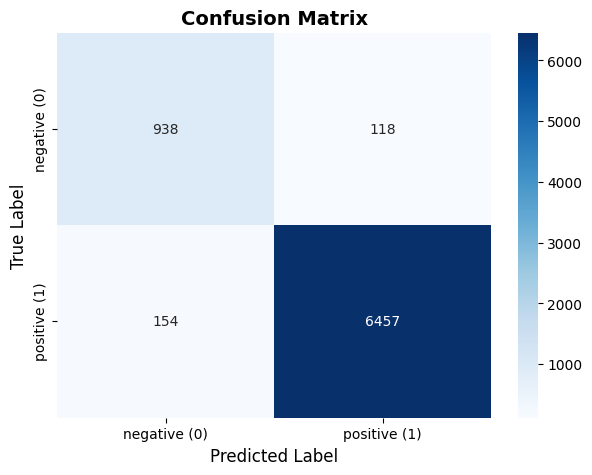

              precision    recall  f1-score   support

negative (0)       0.86      0.89      0.87      1056
positive (1)       0.98      0.98      0.98      6611

    accuracy                           0.96      7667
   macro avg       0.92      0.93      0.93      7667
weighted avg       0.97      0.96      0.96      7667



In [29]:
report, cm = evaluate_model(trainer, test_dataset)
print(report)

In [30]:
hp_output_dir = os.path.join('absa', 'hpt_search_results')
if not os.path.exists(hp_output_dir):
    os.makedirs(hp_output_dir)

In [34]:
def model_init():
    """This function returns a fresh, untrained model."""
    return DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=2
    )

def objective(trial):
  # Define the hyperparameter search space
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
  num_train_epochs = trial.suggest_int("num_train_epochs", 1, 3)

  hpt_args = TrainingArguments(
      output_dir=hp_output_dir,
      learning_rate=learning_rate,
      per_device_train_batch_size=16,
      per_device_eval_batch_size=64,
      num_train_epochs=num_train_epochs,
      weight_decay=0.01,
      eval_strategy="epoch",
      save_strategy="epoch",
      load_best_model_at_end=True,
      metric_for_best_model="f1",
      greater_is_better=True,
      save_total_limit=1,
      logging_strategy="epoch",
      fp16=True,
      remove_unused_columns=False,
      report_to="none"
 )

  hpt_trainer = WeightedTrainer(
      model_init=model_init,
      args=hpt_args,
      train_dataset=train_dataset,
      eval_dataset=eval_dataset,
      compute_metrics=compute_metrics,
      tokenizer=tokenizer
  )

  hpt_trainer.train()

  eval_results = hpt_trainer.evaluate()
  return eval_results["eval_f1"]


In [35]:
# Create and run the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2025-11-09 17:55:07,196] A new study created in memory with name: no-name-1ef2d4f6-aea8-41b0-a915-9f741e8766f7
/tmp/ipython-input-807107604.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  hpt_trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it 

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.281100,0.224820,0.968331,0.968205


[I 2025-11-09 17:57:09,055] Trial 0 finished with value: 0.9683308124739661 and parameters: {'learning_rate': 3.967872434635282e-05, 'num_train_epochs': 1}. Best is trial 0 with value: 0.9683308124739661.
/tmp/ipython-input-807107604.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  hpt_trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifie

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.296600,0.246270,0.962564,0.962172
2,0.139100,0.246424,0.968073,0.967879


[I 2025-11-09 18:01:01,849] Trial 1 finished with value: 0.9680727349331697 and parameters: {'learning_rate': 1.4435846344127412e-05, 'num_train_epochs': 2}. Best is trial 0 with value: 0.9683308124739661.
/tmp/ipython-input-807107604.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  hpt_trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifi

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.295600,0.252132,0.963879,0.963802
2,0.138100,0.288223,0.971489,0.971792
3,0.079500,0.267428,0.975646,0.975705


[I 2025-11-09 18:06:40,647] Trial 2 finished with value: 0.9756463721528463 and parameters: {'learning_rate': 1.4368173785053175e-05, 'num_train_epochs': 3}. Best is trial 2 with value: 0.9756463721528463.
/tmp/ipython-input-807107604.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  hpt_trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifi

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.318900,0.248778,0.953592,0.952389
2,0.175200,0.269738,0.962072,0.961520


[I 2025-11-09 18:10:41,159] Trial 3 finished with value: 0.9620719662994037 and parameters: {'learning_rate': 1.0048552759765654e-05, 'num_train_epochs': 2}. Best is trial 2 with value: 0.9756463721528463.
/tmp/ipython-input-807107604.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  hpt_trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifi

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.284100,0.231118,0.968506,0.968531


[I 2025-11-09 18:12:41,284] Trial 4 finished with value: 0.9685056129628773 and parameters: {'learning_rate': 3.2800617625884455e-05, 'num_train_epochs': 1}. Best is trial 2 with value: 0.9756463721528463.
/tmp/ipython-input-807107604.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  hpt_trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifi

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.282900,0.222225,0.966447,0.966411
2,0.123900,0.240155,0.975855,0.976031
3,0.048200,0.263493,0.978006,0.977988


[I 2025-11-09 18:18:26,510] Trial 5 finished with value: 0.9780055409394945 and parameters: {'learning_rate': 2.2947522074306477e-05, 'num_train_epochs': 3}. Best is trial 5 with value: 0.9780055409394945.
/tmp/ipython-input-807107604.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  hpt_trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifi

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.286300,0.212754,0.971428,0.971466


[I 2025-11-09 18:20:25,151] Trial 6 finished with value: 0.9714275706630935 and parameters: {'learning_rate': 4.317561676563484e-05, 'num_train_epochs': 1}. Best is trial 5 with value: 0.9780055409394945.
/tmp/ipython-input-807107604.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  hpt_trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifie

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.284600,0.222638,0.965904,0.965759


[I 2025-11-09 18:22:24,322] Trial 7 finished with value: 0.965903660206521 and parameters: {'learning_rate': 3.2900350308237455e-05, 'num_train_epochs': 1}. Best is trial 5 with value: 0.9780055409394945.
/tmp/ipython-input-807107604.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  hpt_trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifie

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.289500,0.233826,0.966860,0.966737


[I 2025-11-09 18:24:23,315] Trial 8 finished with value: 0.9668604609334239 and parameters: {'learning_rate': 2.8375602132870323e-05, 'num_train_epochs': 1}. Best is trial 5 with value: 0.9780055409394945.
/tmp/ipython-input-807107604.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  hpt_trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifi

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.284300,0.227901,0.966927,0.966900


[I 2025-11-09 18:26:26,780] Trial 9 finished with value: 0.9669268504497583 and parameters: {'learning_rate': 3.5733037299281114e-05, 'num_train_epochs': 1}. Best is trial 5 with value: 0.9780055409394945.


Best hyperparameters: {'learning_rate': 2.2947522074306477e-05, 'num_train_epochs': 3}


In [36]:
final_training_args = TrainingArguments(
    output_dir=training_output_dir,

    # Use best parameters for training
    num_train_epochs=best_params['num_train_epochs'],
    learning_rate=best_params['learning_rate'],

    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=1,
    logging_strategy="epoch",
    fp16=True,
    remove_unused_columns=False,
    report_to="none"
)
final_model = model_init()

final_trainer = WeightedTrainer(
    model=final_model,
    args=final_training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

final_trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.287000,0.204698,0.965656,0.965270
2,0.119600,0.232648,0.975409,0.975542
3,0.047600,0.270095,0.976076,0.976031


TrainOutput(global_step=4602, training_loss=0.15142507772764813, metrics={'train_runtime': 328.6348, 'train_samples_per_second': 223.936, 'train_steps_per_second': 14.003, 'total_flos': 2437168317322752.0, 'train_loss': 0.15142507772764813, 'epoch': 3.0})

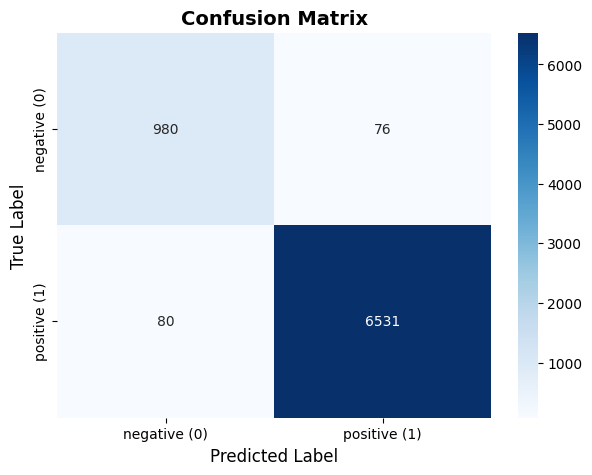

              precision    recall  f1-score   support

negative (0)       0.92      0.93      0.93      1056
positive (1)       0.99      0.99      0.99      6611

    accuracy                           0.98      7667
   macro avg       0.96      0.96      0.96      7667
weighted avg       0.98      0.98      0.98      7667



In [37]:
final_report, final_cm = evaluate_model(final_trainer, test_dataset)
print(final_report)

In [38]:

# Save fine-tuned model
ABSA_MODEL_PATH = os.path.join('absa', 'fine_tuned_bert')
if not os.path.exists(ABSA_MODEL_PATH):
    os.makedirs(ABSA_MODEL_PATH)

final_trainer.save_model(ABSA_MODEL_PATH)
tokenizer.save_pretrained(ABSA_MODEL_PATH)



('absa/fine_tuned_bert/tokenizer_config.json',
 'absa/fine_tuned_bert/special_tokens_map.json',
 'absa/fine_tuned_bert/vocab.txt',
 'absa/fine_tuned_bert/added_tokens.json')

In [39]:
tokenizer = DistilBertTokenizer.from_pretrained(ABSA_MODEL_PATH)
model = DistilBertForSequenceClassification.from_pretrained(ABSA_MODEL_PATH)

# Setup Model for Prediction
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval() # Put the model in "evaluation" mode

id2label = {0: "negative", 1: "positive"}
label2id = {"negative": 0, "positive": 1}

# --- The "Engine" Function (Unchanged) ---
def predict_sentiment(sentence, aspect):
    """
    Runs the BERT model on a single (sentence, aspect) pair.
    """
    inputs = tokenizer(
        sentence,
        aspect,
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.get("logits")
    probabilities = F.softmax(logits, dim=1).cpu().numpy()[0]
    prediction_id = logits.argmax(dim=-1).cpu().item()

    return {
        "label": id2label[prediction_id],
        "score_negative": float(probabilities[label2id["negative"]]),
        "score_positive": float(probabilities[label2id["positive"]]),
    }

# --- Wrapper Function (MODIFIED) ---
def analyze_review(full_review_text: str) -> list:
    """
    Takes a full review text, finds all aspects,
    and returns a list of sentiment predictions.
    (Now uses whole-word matching)
    """
    # Handle null/empty input
    if pd.isna(full_review_text):
        return []

    # Split the review into sentences
    sentences = sent_tokenize(full_review_text)

    results = []
    found_pairs = set() # avoid duplicate (sentence, aspect) predictions

    for sentence in sentences:
        sentence_lower = sentence.lower()

        # Check sentence for each of our aspect keywords
        for aspect, keywords in ASPECT_KEYWORDS.items():
            for keyword in keywords:

                # --- 2. THIS IS THE FIX ---
                # Use re.search with word boundaries (\b)
                # re.escape() handles spaces/special chars, e.g., "air conditioning"
                if re.search(r'\b' + re.escape(keyword) + r'\b', sentence_lower):
                # --- End of Fix ---

                    # Avoid duplicates
                    if (sentence, aspect) in found_pairs:
                        continue

                    try:
                        prediction = predict_sentiment(sentence, aspect)
                        prediction['aspect'] = aspect
                        prediction['sentence'] = sentence
                        results.append(prediction)

                        found_pairs.add((sentence, aspect))

                        # We found this aspect; no need to check
                        # other keywords (like 'suite') for the *same* aspect.
                        # Break and move to the next *aspect* (e.g., "STAFF").
                        break

                    except Exception as e:
                        print(f"Error predicting {aspect} for '{sentence}': {e}")

    return results

In [40]:

# Here is your sample review
sample_review = (
    "Our stay was a mixed bag. The staff at the front desk was so helpful and friendly. "
    "The room was also great, very clean with a nice view. "
    "However, the food in the main restaurant was cold, and the service at the pool bar was just awful."
)

# Run the full pipeline
predictions = analyze_review(sample_review)

# Print the results in a readable format
print(json.dumps(predictions, indent=2))

[
  {
    "label": "positive",
    "score_negative": 7.580898818559945e-05,
    "score_positive": 0.9999241828918457,
    "aspect": "SERVICE",
    "sentence": "The staff at the front desk was so helpful and friendly."
  },
  {
    "label": "positive",
    "score_negative": 7.71893683122471e-05,
    "score_positive": 0.9999227523803711,
    "aspect": "ROOM",
    "sentence": "The room was also great, very clean with a nice view."
  },
  {
    "label": "positive",
    "score_negative": 7.772592653054744e-05,
    "score_positive": 0.9999222755432129,
    "aspect": "LOCATION",
    "sentence": "The room was also great, very clean with a nice view."
  },
  {
    "label": "positive",
    "score_negative": 7.724357419647276e-05,
    "score_positive": 0.9999227523803711,
    "aspect": "CLEANLINESS",
    "sentence": "The room was also great, very clean with a nice view."
  },
  {
    "label": "negative",
    "score_negative": 0.9996685981750488,
    "score_positive": 0.0003314027562737465,
    "a

In [42]:
sample_review_1 = ("Our stay was amazing.")
# Run the full pipeline
predictions = analyze_review(sample_review_1)

# Print the results in a readable format
print(json.dumps(predictions, indent=2))

[]


In [43]:
!mv /content/Grecotel-Project/absa /content/absa